Importing libraries

In [2435]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report,roc_auc_score,confusion_matrix, accuracy_score)
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Importing dataset

In [2436]:
dataset = pd.read_csv('Dataset.csv')
XFull = dataset.iloc[:, :-1]
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

Data Preprocessing

Processing Missing values

In [2437]:
mode_imputer=SimpleImputer(missing_values=np.nan, strategy='median')
col=[6,21,29,11,25]
for i in col:
    mode_imputer.fit(X[:, [i]]) 
    X[:, [i]] = mode_imputer.transform(X[:, [i]])

mode_imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
col=[30,31,27]
for i in col:
    mode_imputer.fit(X[:, [i]]) 
    X[:, [i]] = mode_imputer.transform(X[:, [i]])

col=[3,18]
X = np.where(X == '', np.nan, X)
categorical_imputer = SimpleImputer(strategy='most_frequent')
imputation_ct = ColumnTransformer(transformers=[('cat_imputer', categorical_imputer, col)],remainder='passthrough')
X = imputation_ct.fit_transform(X)


Label Encoding

In [2438]:
le = LabelEncoder() 
for i in [1,3,4,13,14,15,16,17,18,19]:
    X[:,[i]]=le.fit_transform(X[:,i].flatten()).reshape(-1, 1)
y=le.fit_transform(y)

OneHot Encoding

In [2439]:

col=[0,2,5,8,9,10,11]
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), col)], remainder='passthrough') 
X = np.array(ct.fit_transform(X))

col_names = XFull.columns
categorical_names = [col_names[i] for i in col]
ohe = ct.named_transformers_['encoder']
encoded_feature_names = ohe.get_feature_names_out(categorical_names)
remainder_names = [col_names[i] for i in range(len(col_names)) if i not in col]
feature_names = list(encoded_feature_names) + remainder_names

Understanding data

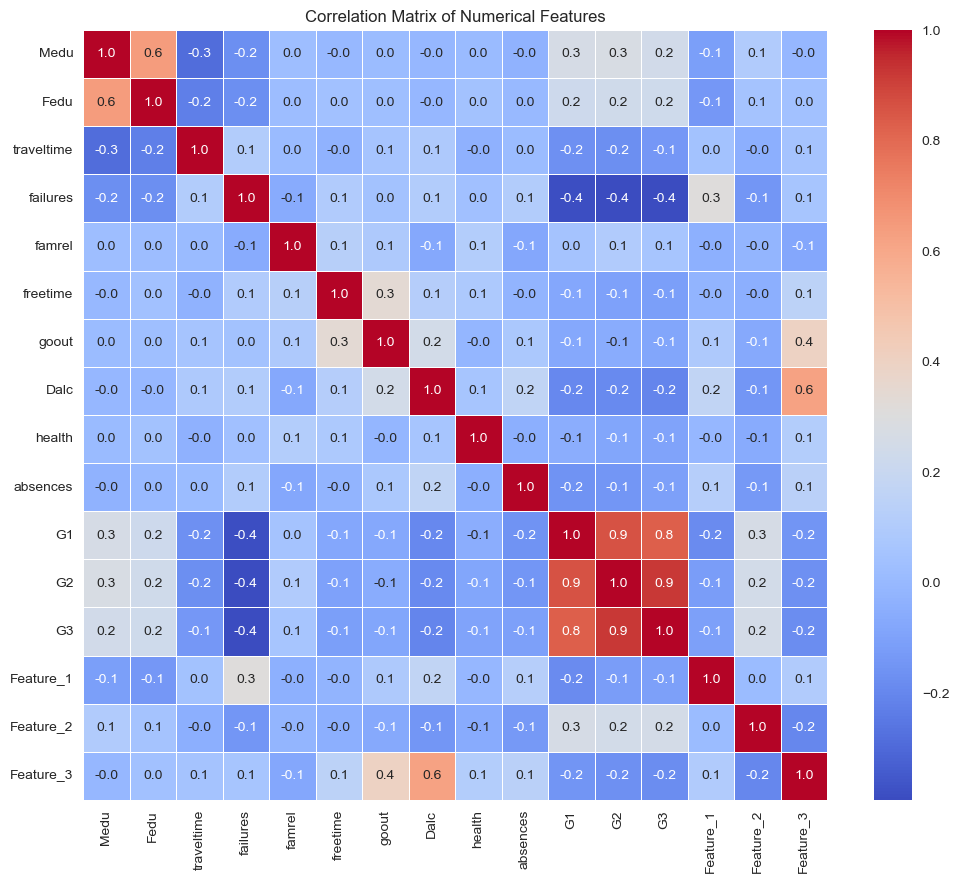

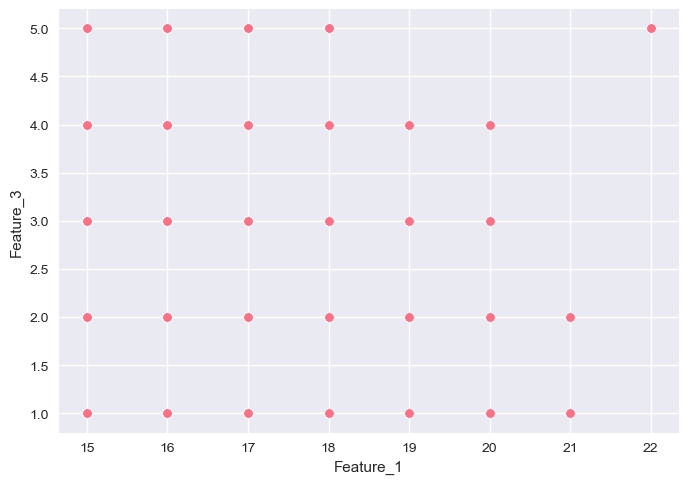

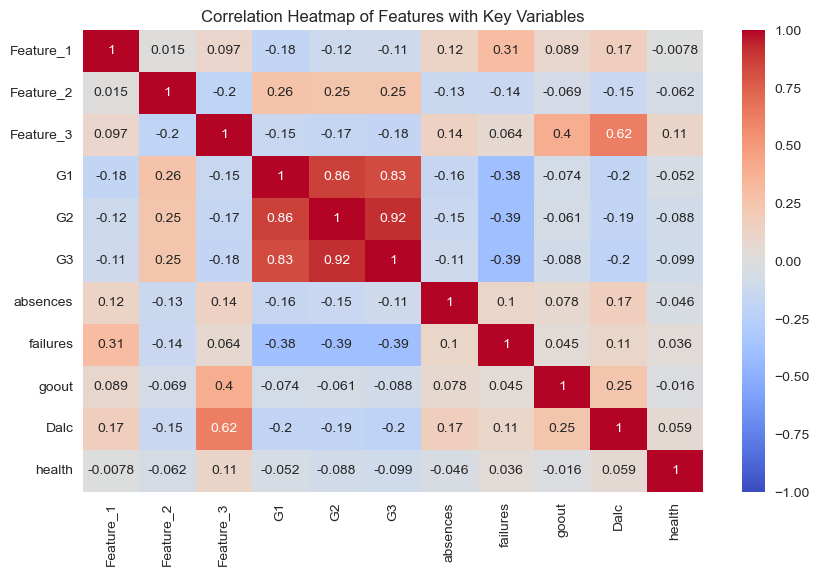

In [2440]:
correlation_matrix = dataset.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()
sns.scatterplot(x="Feature_1",y="Feature_3",data=dataset)
plt.figure(figsize=(10, 6))
subset = dataset[["Feature_1", "Feature_2", "Feature_3", "G1", "G2", "G3", "absences", "failures", "goout", "Dalc", "health"]]
corr = subset.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Features with Key Variables")
plt.show()

Splitting dataset

In [2441]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Training model

In [2442]:

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

'''
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0,max_iter=1000)
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 20, metric = 'minkowski', p = 2)
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0, probability=True)
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)'''
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100,max_features=18, max_depth=10, class_weight='balanced',criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)




RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=18, random_state=0)

Predicting the result

In [2443]:
y_pred = classifier.predict(X_test)

Model accuracy

In [2444]:
y_proba = classifier.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.48).astype(int) 
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
print("Accuracy: ",accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

Confusion matrix:
[[60 21]
 [31 18]]
Accuracy:  0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70        81
           1       0.46      0.37      0.41        49

    accuracy                           0.60       130
   macro avg       0.56      0.55      0.55       130
weighted avg       0.58      0.60      0.59       130

ROC AUC Score: 0.5870


Plotting feature importance

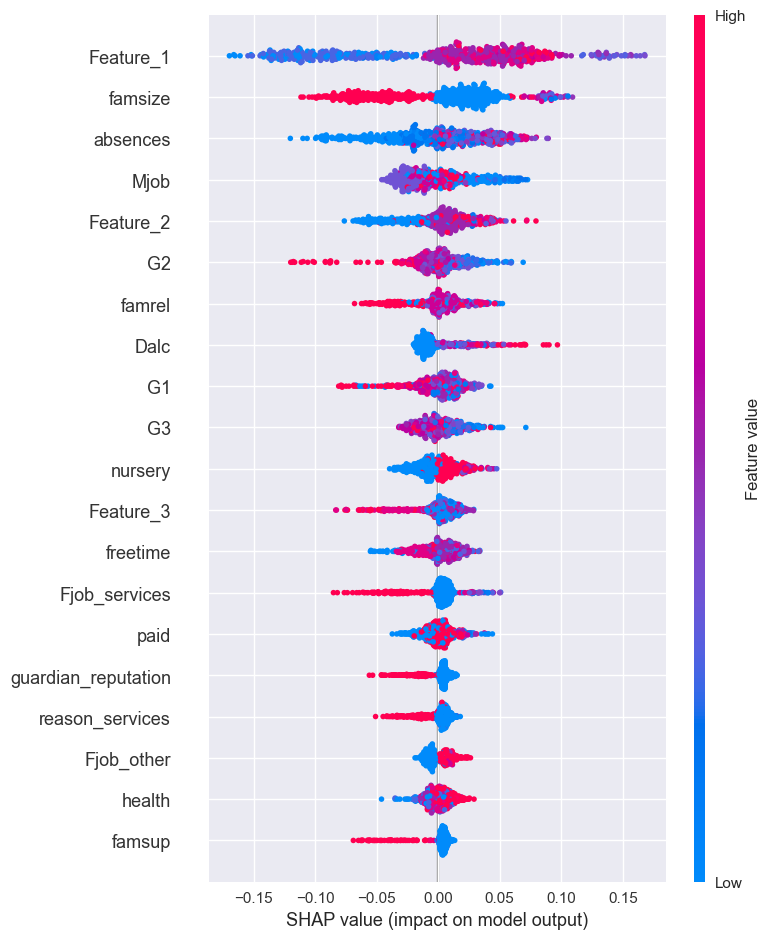

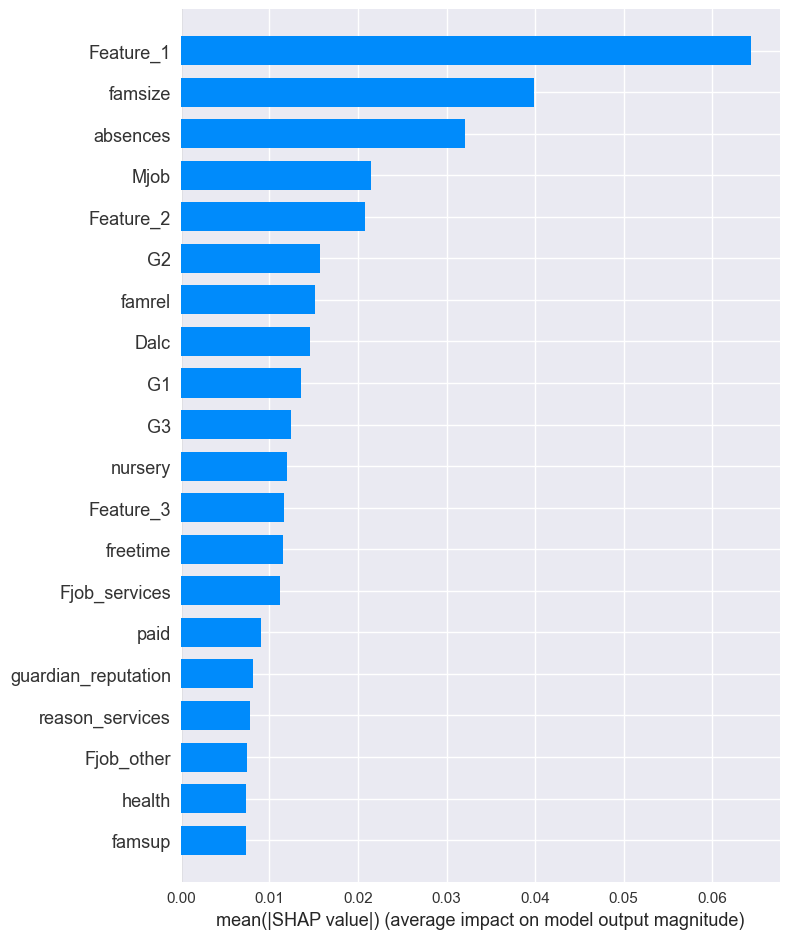

In [2445]:
X_df = pd.DataFrame(X_train, columns=feature_names)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_df)
shap_values_for_plotting = shap_values[:, :, 1]
shap.summary_plot(shap_values_for_plotting, X_df, feature_names=feature_names)
shap.summary_plot(shap_values_for_plotting, X_df, plot_type="bar")
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values_for_plotting[0], X_df.iloc[0])

GRAPHS FOR LEVEL 3

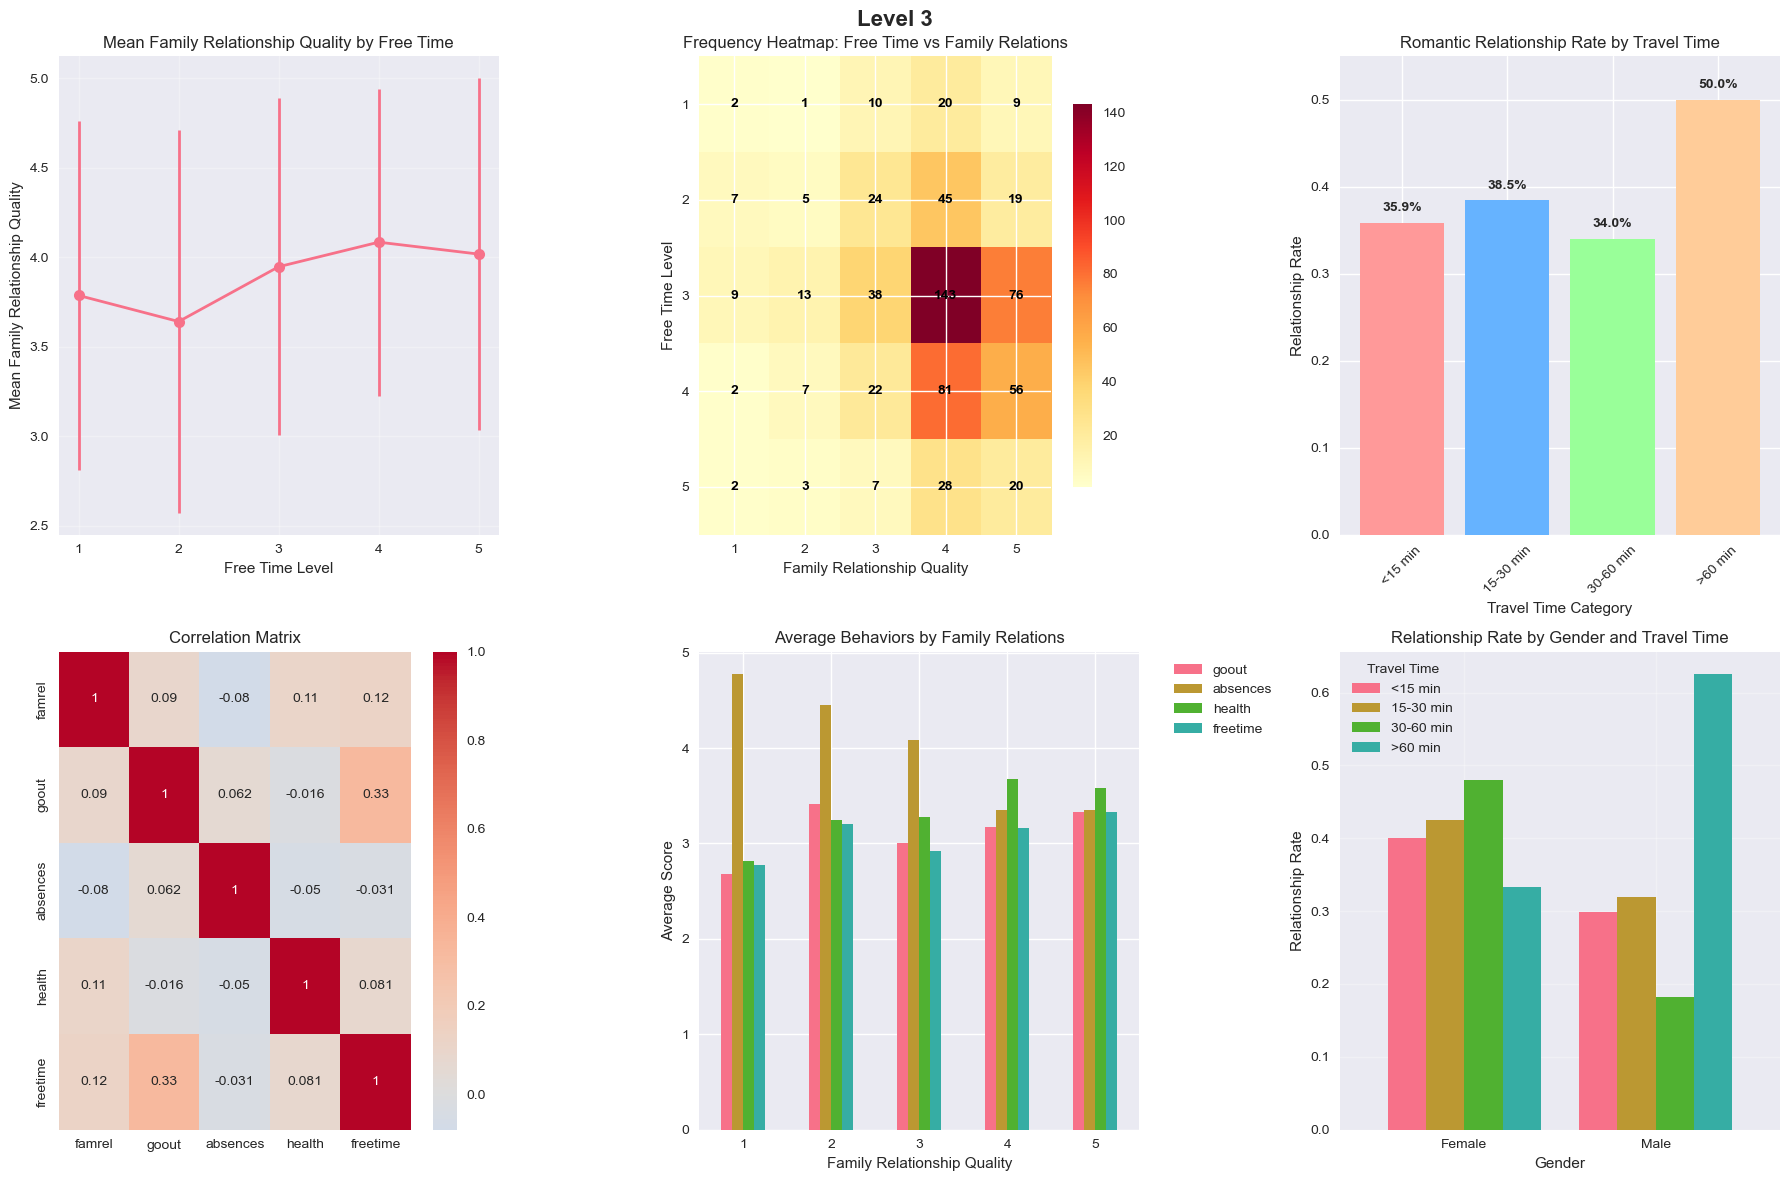

In [2446]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

df = pd.read_csv('Dataset.csv')
col_indices_to_impute = [6, 21, 29, 11, 25] 
column_names_to_impute = [df.columns[i] for i in col_indices_to_impute]
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for col_name in column_names_to_impute:
    mode_imputer.fit(df[[col_name]]) 
    df[col_name] = mode_imputer.transform(df[[col_name]])

col=[30,31,27]
column_names_to_impute = [df.columns[i] for i in col_indices_to_impute]
mode_imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col_name in column_names_to_impute:
    mode_imputer.fit(df[[col_name]]) 
    df[col_name] = mode_imputer.transform(df[[col_name]])

col=[3,18]
df.replace('', np.nan, inplace=True)
col_indices_to_impute = [3, 18]
column_names_to_impute = [df.columns[i] for i in col_indices_to_impute]

categorical_imputer = SimpleImputer(strategy='most_frequent')
imputation_ct = ColumnTransformer(transformers=[('cat_imputer', categorical_imputer, column_names_to_impute)],remainder='passthrough' )
df_transformed_numpy = imputation_ct.fit_transform(df)
passthrough_columns = [col for col in df.columns if col not in column_names_to_impute]
new_column_order = column_names_to_impute + passthrough_columns
df = pd.DataFrame(df_transformed_numpy, columns=new_column_order, index=df.index)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 
for col in [1,3,4,13,14,15,16,17,18,19,32]:  
    col_name = df.columns[col]
    df[col_name] = le.fit_transform(df[col_name])

df['freetime'] = pd.to_numeric(df['freetime'], errors='coerce')
df['famrel'] = pd.to_numeric(df['famrel'], errors='coerce')


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Level 3', fontsize=16, fontweight='bold')

means = df.groupby('freetime')['famrel'].mean()
stds = df.groupby('freetime')['famrel'].std()
axes[0, 0].errorbar(means.index, means.values, yerr=stds.values, 
                    marker='o', linewidth=2, markersize=8, capsize=5)
axes[0, 0].set_title('Mean Family Relationship Quality by Free Time')
axes[0, 0].set_xlabel('Free Time Level')
axes[0, 0].set_ylabel('Mean Family Relationship Quality')
axes[0, 0].set_xticks([1, 2, 3, 4, 5])
axes[0, 0].grid(True, alpha=0.3)


crosstab = pd.crosstab(df['freetime'], df['famrel'])
im = axes[0, 1].imshow(crosstab.values, cmap='YlOrRd', aspect='auto')
axes[0, 1].set_title('Frequency Heatmap: Free Time vs Family Relations')
axes[0, 1].set_xlabel('Family Relationship Quality')
axes[0, 1].set_ylabel('Free Time Level')
axes[0, 1].set_xticks(range(5))
axes[0, 1].set_xticklabels(['1', '2', '3', '4', '5'])
axes[0, 1].set_yticks(range(5))
axes[0, 1].set_yticklabels(['1', '2', '3', '4', '5'])


correlation_matrix = df[['famrel', 'goout', 'absences', 'health', 'freetime']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
axes[1, 0].set_title('Correlation Matrix')


family_summary = df.groupby('famrel')[['goout', 'absences', 'health', 'freetime']].mean()
family_summary.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Family Relationship Quality')
axes[1, 1].set_ylabel('Average Score')
axes[1, 1].set_title('Average Behaviors by Family Relations')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].tick_params(axis='x', rotation=0)


travel_labels = {1: '<15 min', 2: '15-30 min', 3: '30-60 min', 4: '>60 min'}
relationship_rates = df.groupby('traveltime')['romantic'].mean()
bars = axes[0, 2].bar(relationship_rates.index, relationship_rates.values, 
                      color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[0, 2].set_title('Romantic Relationship Rate by Travel Time')
axes[0, 2].set_xlabel('Travel Time Category')
axes[0, 2].set_ylabel('Relationship Rate')
axes[0, 2].set_xticks([1, 2, 3, 4])
axes[0, 2].set_xticklabels([travel_labels[i] for i in [1, 2, 3, 4]], rotation=45)
axes[0, 2].set_ylim(0, max(relationship_rates.values) * 1.1)
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height*100:.1f}%', ha='center', va='bottom', fontweight='bold')
    

gender_travel_romance = df.groupby(['sex', 'traveltime'])['romantic'].mean().unstack()
gender_travel_romance.plot(kind='bar', ax=axes[1,2], width=0.8)
axes[1,2].set_title('Relationship Rate by Gender and Travel Time')
axes[1,2].set_xlabel('Gender')
axes[1,2].set_ylabel('Relationship Rate')
axes[1,2].legend(title='Travel Time', labels=[travel_labels[i] for i in gender_travel_romance.columns])
axes[1,2].set_xticklabels(['Female', 'Male'], rotation=0)
axes[1,2].grid(True, alpha=0.3)


plt.colorbar(im, ax=axes[0, 1], shrink=0.8)


for i in range(5):
    for j in range(5):
        axes[0, 1].text(j, i, str(crosstab.iloc[i, j]), 
                        ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()